### Importing

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

import matplotlib.pyplot as plt
import copy
import pickle
import seaborn as sns

import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

### Methods

In [2]:
def get_split(samples, labels, test_size):
#     return train_test_split(samples, labels,stratify=labels, test_size=test_size,random_state=45)
    return train_test_split(samples, labels,test_size=test_size,random_state=45)

def draw_confusion_matrix(y_actual, y_predicted):
    cm=confusion_matrix(y_actual, y_predicted)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,cmap='tab20c_r'); #annot=True to annotate cells

    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['disease', 'no_disease']);
    ax.yaxis.set_ticklabels(['disease', 'no_disease']);
    plt.show()

def draw_roc(y_actual, scores):
    fpr, tpr, thresholds = roc_curve(y_actual, scores, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr,tpr)
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('1-Specificity = FPR')
    plt.ylabel("Sensitivity = TPR = Recall")
    plt.title("AUC-ROC Curve")
    plt.show()
    
    print('AUC:',roc_auc)

def metric(y_test, y_pred,scores):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn /(tn + fp)
    sensitivity = tp/(tp + fn)
    precission = tp/(tp + fp)
    f1 = (precission * sensitivity * 2) / (precission + sensitivity)
    acc = accuracy_score(y_test, y_pred)
    npv = tn/(tn + fn)
    fpr = fp/(fp + tn)
    rmc = 1.0 - acc
    print("Accuracy    : ", acc)
    print("Specificity : ", specificity)
    print("Sensitivity : ", sensitivity)
    print("Precision   : ", precission)
    print("NPV         : ", npv)
    print("FPR         : ", fpr)
    print("RMC         : ", rmc)
    print("F1          : ", f1)
    
    draw_confusion_matrix(y_test, y_pred)
    draw_roc(y_test,scores)
    

def rc(clfs, dt, lbel, names):
    data = copy.deepcopy(dt)
    label = copy.deepcopy(lbel)
    nfpr = []
    ntpr = []
    pfpr = []
    ptpr = []
    label[label == 1] = 2
    label[label == 0] = 1
    neg_lbl = copy.deepcopy(label)
    pos_lbl = copy.deepcopy(label)
    neg_lbl[neg_lbl == 1] = 1 
    neg_lbl[neg_lbl == 2] = 0
    pos_lbl[pos_lbl == 1] = 0
    pos_lbl[pos_lbl == 2] = 1
    for i in range(len(clfs)):
        prob = clfs[i].predict_proba(data)
        negatives = prob[:,:1]
        positives = prob[:,1:]
        fpr, tpr, thresholds = roc_curve(neg_lbl, negatives, pos_label=None)
        print(len(fpr))
        nfpr.append(fpr)
        ntpr.append(tpr)
        fpr, tpr, thresholds = roc_curve(pos_lbl, positives, pos_label=None)
        pfpr.append(fpr)
        ptpr.append(tpr)
    
    for i in range(len(names)):
        plt.plot(nfpr[i], ntpr[i], label = names[i])
    plt.plot([0,1],[0,1],'k--')
    plt.legend(loc = 'lower right')
    plt.xlabel("True Positive Rate")
    plt.ylabel("False Positive Rate")
    plt.show()
    for i in range(len(names)):
        plt.plot(pfpr[i], ptpr[i], label = names[i])
    plt.plot([0,1],[0,1],'k--')
    plt.legend(loc = 'lower right')
    plt.xlabel("True Positive Rate")
    plt.ylabel("False Positive Rate")
    plt.show()

### Loading dataset and splitting

In [3]:
data = pd.read_csv('heart.csv')
X=data.iloc[:,0:13].values
Y=data[["target"]].values
test_size=0.2
X_train, X_test, y_train, y_test = get_split(X,Y,test_size)

y_train , y_test =y_train.ravel() , y_test.ravel()

### Logistic Regression

[0.85714286 0.78787879 0.86666667 0.82758621 0.88       0.84615385
 0.84615385 0.81481481 0.90909091 0.83333333]
Accuracy    :  0.9016393442622951
Specificity :  0.9565217391304348
Sensitivity :  0.868421052631579
Precision   :  0.9705882352941176
NPV         :  0.8148148148148148
FPR         :  0.043478260869565216
RMC         :  0.09836065573770492
F1          :  0.9166666666666667


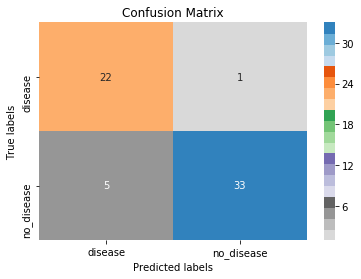

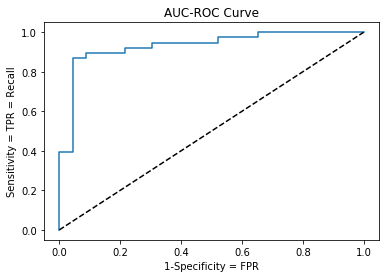

AUC: 0.9324942791762014


In [4]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
logistic = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1', cv=5,n_jobs=-1)

print(cross_val_score(logistic, X_train, y_train, cv=10))

logistic.fit(X_train, y_train)

y_pred = logistic.predict(X_test)

scores=logistic.predict_proba(X_test)[:,1]
metric(y_test, y_pred, scores)

### SVM

Accuracy    :  0.639344262295082
Specificity :  0.043478260869565216
Sensitivity :  1.0
Precision   :  0.6333333333333333
NPV         :  1.0
FPR         :  0.9565217391304348
RMC         :  0.360655737704918
F1          :  0.7755102040816326


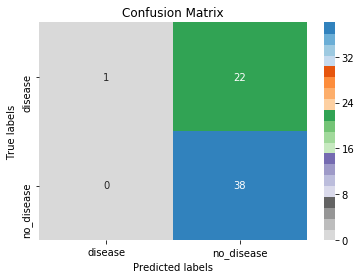

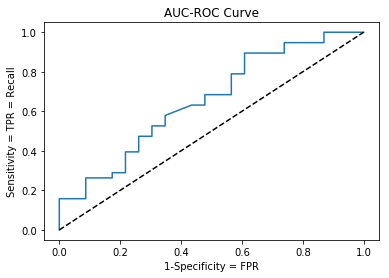

AUC: 0.6544622425629291


In [18]:
rbfsvm =svm.SVC(probability=True)

rbfsvm.fit(X_train, y_train)

y_pred = rbfsvm.predict(X_test)

scores=rbfsvm.predict_proba(X_test)[:,1]
metric(y_test, y_pred, scores)

### KNN

Accuracy    :  0.6721311475409836
Specificity :  0.6086956521739131
Sensitivity :  0.7105263157894737
Precision   :  0.75
NPV         :  0.56
FPR         :  0.391304347826087
RMC         :  0.3278688524590164
F1          :  0.7297297297297298


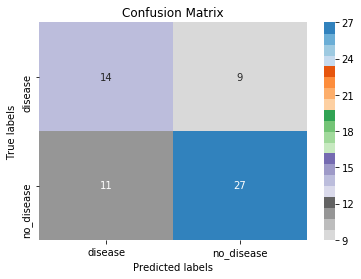

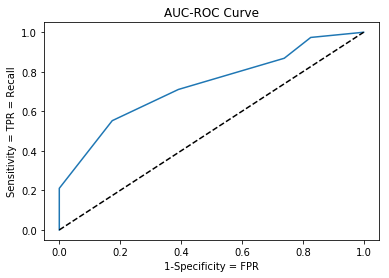

AUC: 0.7299771167048055


In [6]:
knn=KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

scores=knn.predict_proba(X_test)[:,1]
metric(y_test, y_pred, scores)

### NB

Accuracy    :  0.819672131147541
Specificity :  0.8695652173913043
Sensitivity :  0.7894736842105263
Precision   :  0.9090909090909091
NPV         :  0.7142857142857143
FPR         :  0.13043478260869565
RMC         :  0.180327868852459
F1          :  0.8450704225352113


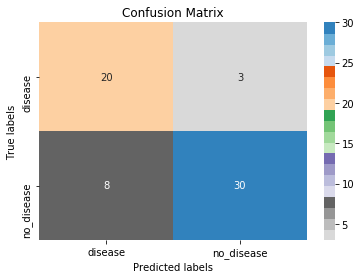

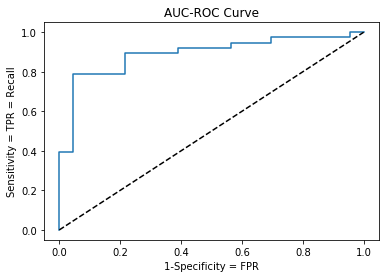

AUC: 0.891304347826087


In [7]:
nb = GaussianNB()
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

scores=nb.predict_proba(X_test)[:,1]
metric(y_test, y_pred, scores)

### Decision Tree

[0.68       0.64       0.92       0.72       0.8        0.83333333
 0.66666667 0.82608696 0.7826087  0.86956522]
Accuracy    :  0.7540983606557377
Specificity :  0.782608695652174
Sensitivity :  0.7368421052631579
Precision   :  0.8484848484848485
NPV         :  0.6428571428571429
FPR         :  0.21739130434782608
RMC         :  0.24590163934426235
F1          :  0.7887323943661972


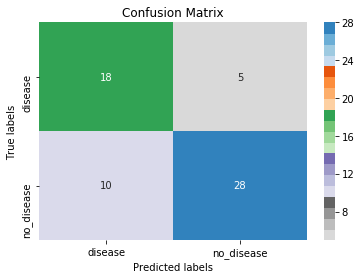

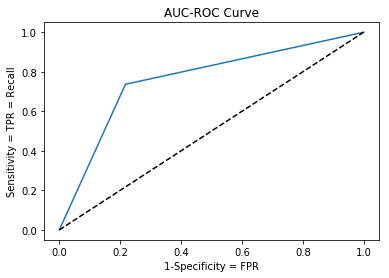

AUC: 0.7597254004576659


In [8]:
dtree = DecisionTreeClassifier(random_state=0)

print(cross_val_score(dtree, X_train, y_train, cv=10))

dtree.fit(X_train, y_train)

y_pred = dtree.predict(X_test)

scores=dtree.predict_proba(X_test)[:,1]
metric(y_test, y_pred, scores)

### MLP

[0.8        0.64       0.84       0.72       0.72       0.875
 0.83333333 0.82608696 0.91304348 0.82608696]
Accuracy    :  0.8688524590163934
Specificity :  0.8260869565217391
Sensitivity :  0.8947368421052632
Precision   :  0.8947368421052632
NPV         :  0.8260869565217391
FPR         :  0.17391304347826086
RMC         :  0.1311475409836066
F1          :  0.8947368421052632


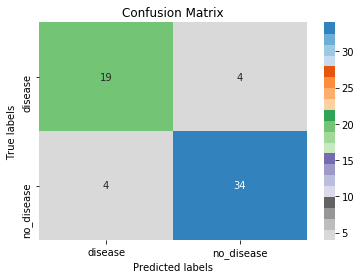

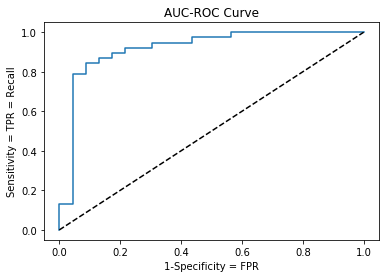

AUC: 0.9187643020594967


In [9]:
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(3,2), random_state=1)

print(cross_val_score(mlp, X_train, y_train, cv=10))

mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

scores=mlp.predict_proba(X_test)[:,1]
metric(y_test, y_pred,scores)

### Random Forest

[0.84       0.72       0.88       0.76       0.88       0.79166667
 0.83333333 0.86956522 0.82608696 0.7826087 ]
Accuracy    :  0.8360655737704918
Specificity :  0.8695652173913043
Sensitivity :  0.8157894736842105
Precision   :  0.9117647058823529
NPV         :  0.7407407407407407
FPR         :  0.13043478260869565
RMC         :  0.16393442622950816
F1          :  0.861111111111111


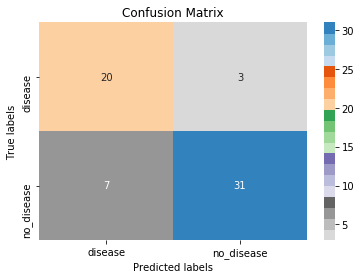

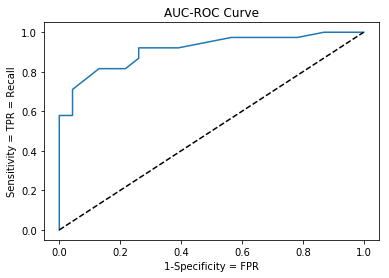

AUC: 0.9118993135011443


In [10]:
rforest = RandomForestClassifier(n_estimators = 20)

print(cross_val_score(rforest, X_train, y_train, cv=10))

rforest.fit(X_train, y_train)

y_pred = rforest.predict(X_test)

scores=rforest.predict_proba(X_test)[:,1]
metric(y_test, y_pred,scores)

16
27
7
15
3
20
19


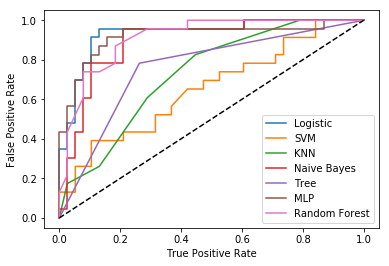

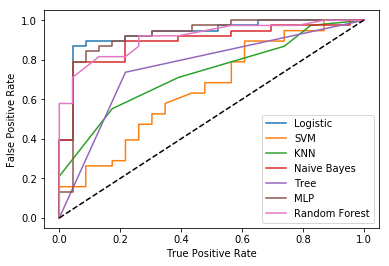

In [12]:
rc([logistic,rbfsvm,knn,nb,dtree, mlp, rforest], X_test, y_test, ['Logistic','SVM','KNN','Naive Bayes','Tree', 'MLP', 'Random Forest'])